<a href="https://colab.research.google.com/github/mishraaayushman3/Chest-Xray-analysis/blob/master/Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Import the libraries and data

In [39]:
%tensorflow_version 1.14
import numpy as np
import pandas as pd
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from os import listdir
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import img_to_array
import cv2
from keras.applications import imagenet_utils
import keras.backend as K
from skimage.transform import resize
from keras import Model

#All the keras pre-trained models
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet import ResNet101
from keras.applications.densenet import DenseNet201

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.14`. This will be interpreted as: `1.x`.


TensorFlow is already loaded. Please restart the runtime to change versions.


In [40]:
#Read the sample_labels.csv into a pandas dataframe
all_xray_df = pd.read_csv('drive/My Drive/Chest_data/sample/sample_labels.csv')
all_image_paths = {os.path.basename(f): f  for f in listdir("drive/My Drive/Chest_data/sample/images")   }      
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)

Scans found: 5606 , Total Headers 5606


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
4834,00025423_000.png,Infiltration,0,25423,57,F,PA,2992,2989,0.143,0.143,00025423_000.png
1510,00007882_002.png,No Finding,2,7882,58,M,AP,2048,2500,0.168,0.168,00007882_002.png
4992,00026342_000.png,No Finding,0,26342,70,M,PA,2544,3056,0.139,0.139,00026342_000.png


## Visualisation

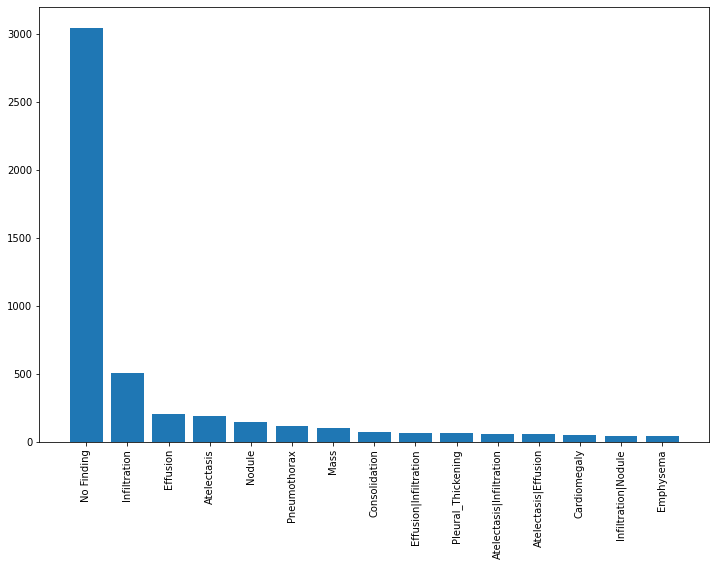

In [4]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

## Pre Processing

In [0]:
# Since the image may contain multiple disease labels
# Create a list of all disesases and append a new column named output to the x_ray dataframe
all_xray_df['disease_vec']=all_xray_df['Finding Labels'].apply(lambda x: x.split('|'))

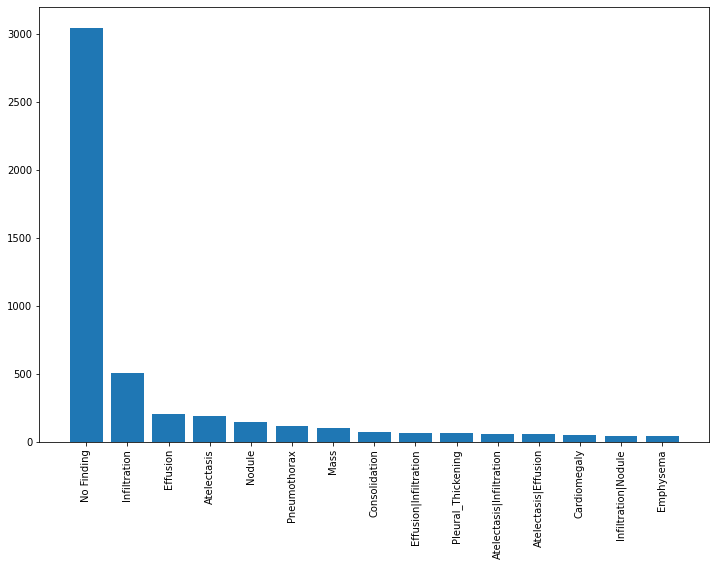

In [42]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(5606, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [0]:
all_labels=['Atelectasis','Cardiomegaly','Effusion','Infiltration','Mass','Nodule','Pneumonia','Pneumothorax','Consolidation','Edema','Emphysema','Fibrosis','Pleural Thickening','Hernia']

## Splitting the dataset

In [44]:
# 20% of the data will be used for testing of model performance
# random state is set so as to get the same split everytime
# stratify is used to have equal proportion of output label in training and validation set
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.25, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 4204 validation 1402


In [0]:
#creating an Image Data generator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15,
                              validation_split = 0.1)

In [46]:
# obtaing the training images using the above generator
train_gen = core_idg.flow_from_dataframe(
        dataframe=train_df,
        directory='drive/My Drive/Chest_data/sample/images',
        x_col='path',
        y_col='disease_vec',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',subset='training')

Found 3784 validated image filenames belonging to 15 classes.


In [47]:
# print the output classes in ImageDataGenerator train_gen
train_gen.class_indices.keys()

dict_keys(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax'])

In [48]:
# obtaing the validation images using the above generator
valid_gen = core_idg.flow_from_dataframe(
        dataframe=train_df,
        directory='drive/My Drive/Chest_data/sample/images',
        x_col='path',
        y_col='disease_vec',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical',subset='validation')

Found 420 validated image filenames belonging to 15 classes.


In [49]:
#select a batch of images used for prediction on trained model
test_X, test_Y = next(core_idg.flow_from_dataframe(
        dataframe=train_df,
        directory='drive/My Drive/Chest_data/sample/images',
        x_col='path',
        y_col='disease_vec',
        target_size=(128, 128),
        batch_size=32,
        class_mode='categorical')) # one big batch

Found 4204 validated image filenames belonging to 15 classes.


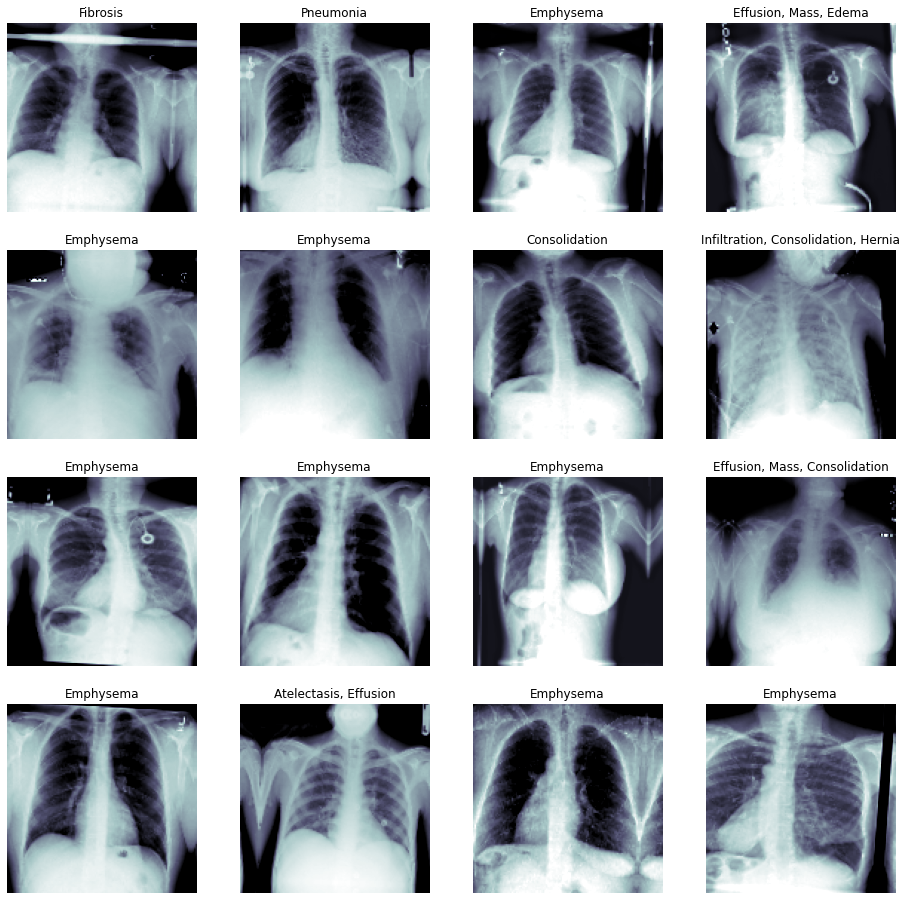

In [50]:
t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

## Creating model using Keras Functional Model

In [0]:
# create a function to return a mobileNet Model with the output layer having 15 output units
def get_mobilenet():
  base_mobilenet_model = MobileNet( input_shape =  (128,128,3), include_top = False, weights = None)
  pooling_layer=GlobalAveragePooling2D()(base_mobilenet_model.output)
  dropout_layer1=Dropout(0.5)(pooling_layer)
  dense_layer1=Dense(512)(dropout_layer1)
  dropout_layer2=Dropout(0.5)(dense_layer1)
  dense_layer2=Dense(15,activation='sigmoid')(dropout_layer2)
  model=Model(inputs=base_mobilenet_model.inputs,outputs=dense_layer2)
  return model

In [0]:
# create a function to return a denseNet Model with the output layer having 15 output units
def get_densenet():
  base_densenet_model = DenseNet201( input_shape =  (128,128,3), include_top = False, weights = None)
  pooling_layer=GlobalAveragePooling2D()(base_densenet_model.output)
  dropout_layer1=Dropout(0.5)(pooling_layer)
  dense_layer1=Dense(512)(dropout_layer1)
  dropout_layer2=Dropout(0.5)(dense_layer1)
  dense_layer2=Dense(15,activation='sigmoid')(dropout_layer2)
  model=Model(inputs=base_densenet_model.inputs,outputs=dense_layer2)
  return model

In [0]:
# create a function to return a inception Model with the output layer having 15 output units
def get_inception():
  base_inception_model = InceptionV3( input_shape =  (128,128,3), include_top = False, weights = None)
  pooling_layer=GlobalAveragePooling2D()(base_inception_model.output)
  dropout_layer1=Dropout(0.5)(pooling_layer)
  dense_layer1=Dense(512)(dropout_layer1)
  dropout_layer2=Dropout(0.5)(dense_layer1)
  dense_layer2=Dense(15,activation='sigmoid')(dropout_layer2)
  model=Model(inputs=base_inception_model.inputs,outputs=dense_layer2)
  return model

In [0]:
# create a function to return a resnet Model with the output layer having 15 output units
def get_resnet():
  base_resnet_model = ResNet101( input_shape =  (128,128,3), include_top = False, weights = None)
  pooling_layer=GlobalAveragePooling2D()(base_resnet_model.output)
  dropout_layer1=Dropout(0.5)(pooling_layer)
  dense_layer1=Dense(512)(dropout_layer1)
  dropout_layer2=Dropout(0.5)(dense_layer1)
  dense_layer2=Dense(15,activation='sigmoid')(dropout_layer2)
  model=Model(inputs=base_resnet_model.inputs,outputs=dense_layer2)
  return model

In [0]:
# create a function to return a VGG16 Model with the output layer having 15 output units
def get_VGG16():
  base_VGG16_model = VGG16( input_shape =  (128,128,3), include_top = False, weights = None)
  pooling_layer=GlobalAveragePooling2D()(base_VGG16_model.output)
  dropout_layer1=Dropout(0.5)(pooling_layer)
  dense_layer1=Dense(512)(dropout_layer1)
  dropout_layer2=Dropout(0.5)(dense_layer1)
  dense_layer2=Dense(15,activation='sigmoid')(dropout_layer2)
  model=Model(inputs=base_VGG16_model.inputs,outputs=dense_layer2)
  return model

In [0]:
# create a function to return a VGG19 Model with the output layer having 15 output units
def get_VGG19():
  base_VGG19_model = VGG19( input_shape =  (128,128,3), include_top = False, weights = None)
  pooling_layer=GlobalAveragePooling2D()(base_VGG19_model.output)
  dropout_layer1=Dropout(0.5)(pooling_layer)
  dense_layer1=Dense(512)(dropout_layer1)
  dropout_layer2=Dropout(0.5)(dense_layer1)
  dense_layer2=Dense(15,activation='sigmoid')(dropout_layer2)
  model=Model(inputs=base_VGG19_model.inputs,outputs=dense_layer2)
  return model

##Comparing 6 different Transfer learning Models

In [0]:
labels = ["MobileNet","ResNet101","VGG16","InceptionV3","VGG19","DenseNet201"]

In [64]:
models = [get_mobilenet,get_resnet,get_VGG16,get_inception,get_VGG19,get_densenet]

loss = []
binaryAccuracy = []
meanAbsoluteError = []
idx = 0
for model in models:
  # creating a callback to store the best model
  weight_path="{}_weights.best.hdf5".format('xray_'+labels[idx])
  idx += 1

  checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                              save_best_only=True, mode='min', save_weights_only = True)

  early = EarlyStopping(monitor="val_loss", 
                        mode="min", 
                        patience=3)
  callbacks_list = [checkpoint, early]
  multi_disease_model = model()
  multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
  multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=5,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1,
                                  callbacks = callbacks_list)
  
  # load the best weights
  multi_disease_model.load_weights(weight_path)

  # predict on the test_X batch of the validation set
  res = multi_disease_model.evaluate(test_X,test_Y, batch_size = 32, verbose = True)
  loss.append(res[0])
  binaryAccuracy.append(res[1])
  meanAbsoluteError.append(res[2])
  print('loss = ',res[0])
  print('Binary accuracy = ',res[1])
  print('Mean absolute error',res[2])

Epoch 1/1
5/5 [==============================] - 62s 12s/step - loss: 0.4286 - binary_accuracy: 0.8183 - mae: 0.2161 - val_loss: 0.6536 - val_binary_accuracy: 0.9083 - val_mae: 0.4797

Epoch 00001: val_loss improved from inf to 0.65363, saving model to xray_MobileNet_weights.best.hdf5
32/32 [==============================] - 0s 1ms/step
loss =  0.6536296010017395
Binary accuracy =  0.9083333015441895
Mean absolute error 0.47968581318855286
Epoch 1/1
5/5 [==============================] - 52s 10s/step - loss: 1.1001 - binary_accuracy: 0.8054 - mae: 0.1970 - val_loss: 24.7017 - val_binary_accuracy: 0.9083 - val_mae: 0.0917

Epoch 00001: val_loss improved from inf to 24.70172, saving model to xray_ResNet101_weights.best.hdf5
32/32 [==============================] - 0s 7ms/step
loss =  24.70172119140625
Binary accuracy =  0.9083333015441895
Mean absolute error 0.09166669845581055
Epoch 1/1
5/5 [==============================] - 82s 16s/step - loss: 10.1997 - binary_accuracy: 0.8204 - mae: 

In [72]:
#clipping loss with very high values
for i in range(0,len(loss)):
  if(loss[i] > 1):
    loss[i] = 1
print(loss)
print(binaryAccuracy)
print(meanAbsoluteError)

[0.6536296010017395, 1, 0.6713459491729736, 0.5919219255447388, 0.667454719543457, 0.4838812053203583]
[0.9083333015441895, 0.9083333015441895, 0.8500000238418579, 0.9083333015441895, 0.8500000238418579, 0.8937499523162842]
[0.47968581318855286, 0.09166669845581055, 0.4889006018638611, 0.4452815055847168, 0.4868432581424713, 0.12785059213638306]


##Plotting results of different models

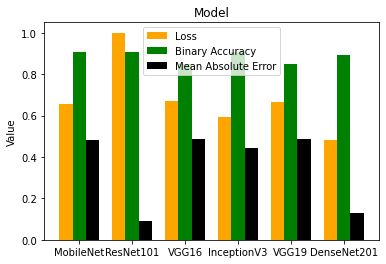

In [74]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np


#labels = ["MobileNet","ResNet101","VGG16","InceptionV3","VGG19","DenseNet201"]

x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, loss, width, label='Loss',color='orange')
rects2 = ax.bar(x, binaryAccuracy, width, label='Binary Accuracy',color='green')
rects3 = ax.bar(x +width, meanAbsoluteError, width, label='Mean Absolute Error',color='black')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Value')
ax.set_title('Model')
ax.set_xticks(x)
ax.set_xticklabels(labels)

ax.legend()


##Saving the Model Weights

In [0]:
# creating a callback to store the best model
weight_path="{}_weights.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

## Training of the best model

In [80]:
# start training the model
model = models[binaryAccuracy.index(max(binaryAccuracy))]
multi_disease_model = model()
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.fit_generator(train_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 2, 
                                  callbacks = callbacks_list)

Epoch 1/2
100/100 [==============================] - 681s 7s/step - loss: 0.3033 - binary_accuracy: 0.9118 - mae: 0.1222 - val_loss: 0.2477 - val_binary_accuracy: 0.9083 - val_mae: 0.1553

Epoch 00001: val_loss improved from inf to 0.24771, saving model to xray_class_weights.best.hdf5
Epoch 2/2
100/100 [==============================] - 101s 1s/step - loss: 0.2431 - binary_accuracy: 0.9195 - mae: 0.1214 - val_loss: 0.2864 - val_binary_accuracy: 0.9208 - val_mae: 0.0968

Epoch 00002: val_loss did not improve from 0.24771


## Testing the performance of the best model

In [0]:
# load the best weights
multi_disease_model.load_weights(weight_path)

In [82]:
# predict on the test_X batch of the validation set
res = multi_disease_model.evaluate(test_X,test_Y, batch_size = 32, verbose = True)
print('loss = ',res[0])
print('Binary accuracy = ',res[1])
print('Mean absolute error',res[2])

32/32 [==============================] - 0s 2ms/step
loss =  0.24770838022232056
Binary accuracy =  0.9083333015441895
Mean absolute error 0.15527984499931335


##Making the Prediction 

In [0]:
pred_Y = multi_disease_model.predict(test_X,batch_size = 32,verbose= True)

1024/1024 [==============================] - 0s 423us/step


##Ploting ROC curves

In [0]:
from collections import Counter
Counter(test_Y[0])

Counter({0.0: 14, 1.0: 1})

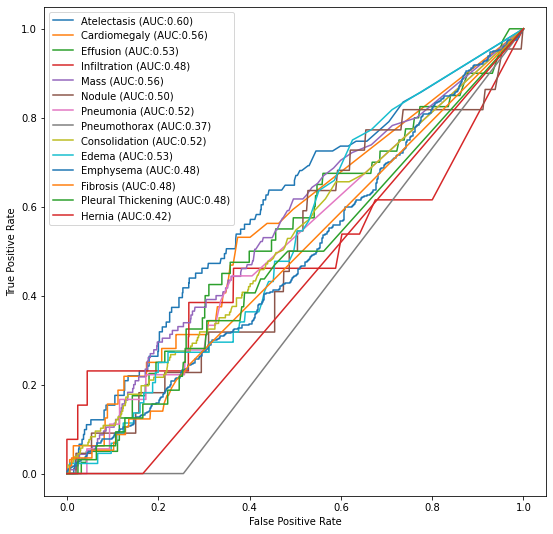

In [0]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net.png')

## Heat map using Grad Cam

In [0]:
img_path='drive/My Drive/Chest_data/sample/images/00019150_008.png'
img=cv2.imread(img_path)
img=cv2.resize(img,IMG_SIZE)
img.shape

(128, 128, 3)

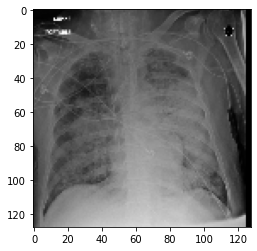

In [0]:
plt.imshow(img)

In [0]:
def preprocess(img):
    img = img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = imagenet_utils.preprocess_input(img)
    return img
image1 = preprocess(img)

In [0]:
plt.imshow(image1[0])

In [0]:
predict = multi_disease_model.predict(image1)
print(decode_predictions(predict,top=3))
target_class = np.argmax(predict[0])
print("Target Class = %d"%target_class)

In [0]:
def find_target_layer():
  for layer in reversed(multi_disease_model.layers):
    if len(layer.output_shape) == 4:
      return layer.name

In [0]:
layer=find_target_layer()
#layer='block5_conv3'
print(layer)

block5_pool


In [0]:
last_conv = multi_disease_model.get_layer(layer)
grads = K.gradients(multi_disease_model.output[:,target_class],last_conv.output)[0]

In [0]:
pooled_grads = K.mean(grads,axis=(0,1,2))
iterate = K.function([multi_disease_model.input],[pooled_grads,last_conv.output[0]])
pooled_grads_value,conv_layer_output = iterate([image1])

In [0]:
for i in range(pooled_grads_value.shape[0]):
    conv_layer_output[:,:,i] *= pooled_grads_value[i]
heatmap = np.mean(conv_layer_output,axis=-1)

In [0]:
#for x in range(heatmap.shape[0]):
#    for y in range(heatmap.shape[1]):
#        heatmap[x,y] = np.max(heatmap[x,y],0)

In [0]:
heatmap = np.maximum(heatmap,0)
print(np.max(heatmap))

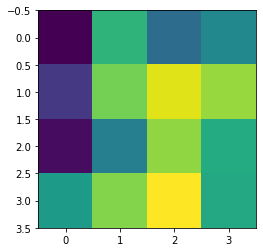

In [0]:
heatmap /= np.max(heatmap)
plt.imshow(heatmap)

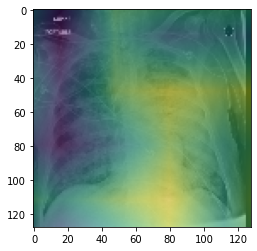

In [0]:
upsample = resize(heatmap, IMG_SIZE,preserve_range=True)
plt.imshow(img1)
plt.imshow(upsample,alpha=0.5)
plt.show()

## Random stuff

In [0]:
model = VGG16(weights='imagenet',include_top=False,input_shape=(300,300,3))
f=GlobalAveragePooling2D()(model.output)
layer1 = Dense(10)(f)
x=Model(inputs=model.inputs,outputs=layer1)

In [0]:
for layer in multi_disease_model.layers:
  print(layer)

In [0]:
print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     